In [1]:
import pandas as pd
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.model_selection import GridSearchCV

In [2]:
train = pd.read_csv('./train.csv')
test = pd.read_csv('./test.csv')
origin = pd.read_csv('./WineQT.csv')

In [3]:
train = pd.concat([train,origin],axis=0).drop('Id',axis=1).drop_duplicates().reset_index(drop=True)

In [4]:
train.quality.value_counts()

5    1272
6    1187
7     455
4      88
8      54
3      18
Name: quality, dtype: int64

In [5]:
train

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,8.0,0.500,0.39,2.2,0.073,30.0,39.0,0.99572,3.33,0.77,12.1,6
1,9.3,0.300,0.73,2.3,0.092,30.0,67.0,0.99854,3.32,0.67,12.8,6
2,7.1,0.510,0.03,2.1,0.059,3.0,12.0,0.99660,3.52,0.73,11.3,7
3,8.1,0.870,0.22,2.6,0.084,11.0,65.0,0.99730,3.20,0.53,9.8,5
4,8.5,0.360,0.30,2.3,0.079,10.0,45.0,0.99444,3.20,1.36,9.5,6
...,...,...,...,...,...,...,...,...,...,...,...,...
3069,6.3,0.510,0.13,2.3,0.076,29.0,40.0,0.99574,3.42,0.75,11.0,6
3070,6.8,0.620,0.08,1.9,0.068,28.0,38.0,0.99651,3.42,0.82,9.5,6
3071,6.2,0.600,0.08,2.0,0.090,32.0,44.0,0.99490,3.45,0.58,10.5,5
3072,5.9,0.550,0.10,2.2,0.062,39.0,51.0,0.99512,3.52,0.76,11.2,6


In [6]:
train['quality'] = [i-3 for i in train['quality']]

<AxesSubplot: ylabel='Frequency'>

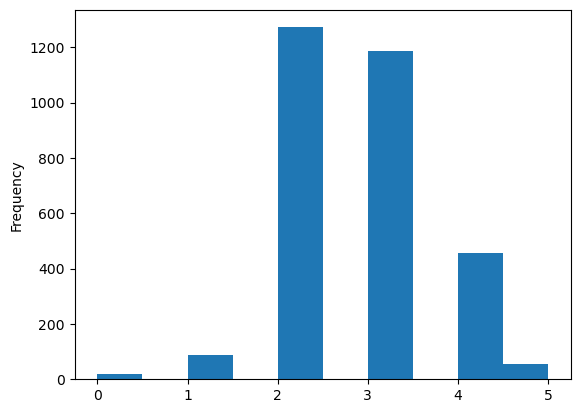

In [7]:
train.quality.plot.hist()

In [8]:
from lightgbm import LGBMClassifier
lgb = LGBMClassifier()

In [9]:
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler, MinMaxScaler, Normalizer, RobustScaler, LabelEncoder, OneHotEncoder
from sklearn.metrics import mean_squared_error, roc_auc_score, accuracy_score, f1_score, cohen_kappa_score
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.model_selection import GridSearchCV
from category_encoders import LeaveOneOutEncoder

from catboost import CatBoostClassifier, CatBoostRegressor
from xgboost import XGBClassifier, XGBRFRegressor
from lightgbm.sklearn import LGBMClassifier, LGBMRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import ExtraTreesClassifier

import optuna
from optuna.samplers import TPESampler

import warnings

warnings.filterwarnings('ignore')

C:\Users\user\anaconda3\envs\ml\lib\site-packages\xgboost\compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [10]:
target = 'quality'
features = [c for c in train.columns if c not in [target]]

In [11]:
kf = StratifiedKFold(n_splits = 5, random_state = 11, shuffle = True)
models = []
val_scores = []
preds = []

# params = {
# 'n_estimators':15000,
# 'max_depth':5,
# 'early_stopping_rounds':200,
# 'learning_rate':0.005,
# 'one_hot_max_size':3,
# 'bootstrap_type':"MVS",
# 'l2_leaf_reg':2,
# 'random_state':1
#          }

for i, (train_index, val_index) in tqdm(enumerate(kf.split(train, train[target]))):
    
    X_train, X_val = train[features].loc[train_index], train[features].loc[val_index]
    y_train, y_val = train[target][train_index], train[target][val_index]
    
#     if include_orig:
#         X_train = X_train.append(original[features], ignore_index = True)
#         y_train = y_train.append(original[target], ignore_index = True)
    
    model = CatBoostClassifier(random_state=11)
    
    model.fit(X_train, y_train, eval_set = [(X_val, y_val)], verbose = 2000)
    
    models.append(model)
    # pred = model.predict_proba(X_val)[:,1]
    # score = accuracy_score(y_val, model.predict(X_val))
    score = cohen_kappa_score(y_val, model.predict(X_val), weights = 'quadratic')

    val_scores.append(score)
    
    print(f'ACC on fold {i}: {score:.4f}')
    
print(f'mean AUC across all folds: {np.mean(val_scores):.4f}')

0it [00:00, ?it/s]

Learning rate set to 0.109937
0:	learn: 1.6480794	test: 1.6523132	best: 1.6523132 (0)	total: 167ms	remaining: 2m 46s


1it [00:04,  4.03s/it]

999:	learn: 0.1649664	test: 1.1673807	best: 0.9996914 (82)	total: 3.86s	remaining: 0us

bestTest = 0.999691392
bestIteration = 82

Shrink model to first 83 iterations.
ACC on fold 0: 0.5006
Learning rate set to 0.109937
0:	learn: 1.6575814	test: 1.6633682	best: 1.6633682 (0)	total: 4.46ms	remaining: 4.45s


2it [00:07,  3.98s/it]

999:	learn: 0.1628073	test: 1.1327799	best: 0.9912570 (108)	total: 3.77s	remaining: 0us

bestTest = 0.9912569522
bestIteration = 108

Shrink model to first 109 iterations.
ACC on fold 1: 0.5226
Learning rate set to 0.109937
0:	learn: 1.6536630	test: 1.6560167	best: 1.6560167 (0)	total: 4.98ms	remaining: 4.98s


3it [00:12,  4.01s/it]

999:	learn: 0.1652301	test: 1.1197127	best: 0.9767536 (76)	total: 3.88s	remaining: 0us

bestTest = 0.9767536003
bestIteration = 76

Shrink model to first 77 iterations.
ACC on fold 2: 0.5214
Learning rate set to 0.109937
0:	learn: 1.6596603	test: 1.6618810	best: 1.6618810 (0)	total: 9.76ms	remaining: 9.75s


4it [00:15,  3.99s/it]

999:	learn: 0.1637620	test: 1.1440063	best: 0.9868184 (107)	total: 3.78s	remaining: 0us

bestTest = 0.9868183927
bestIteration = 107

Shrink model to first 108 iterations.
ACC on fold 3: 0.4863
Learning rate set to 0.109938
0:	learn: 1.6609886	test: 1.6678875	best: 1.6678875 (0)	total: 45.6ms	remaining: 45.5s


5it [00:19,  3.99s/it]

999:	learn: 0.1657767	test: 1.1613158	best: 0.9913439 (77)	total: 3.8s	remaining: 0us

bestTest = 0.9913438703
bestIteration = 77

Shrink model to first 78 iterations.
ACC on fold 4: 0.5011
mean AUC across all folds: 0.5064


In [12]:
val_scores

[0.5005633009435291,
 0.5225716240466061,
 0.5213830944347838,
 0.4863409555946441,
 0.5011240802435108]

In [13]:
kf = StratifiedKFold(n_splits = 5, random_state = 11, shuffle = True)
val_scores = []

# params = {
# 'n_estimators':15000,
# 'max_depth':5,
# 'early_stopping_rounds':200,
# 'learning_rate':0.005,
# 'one_hot_max_size':3,
# 'bootstrap_type':"MVS",
# 'l2_leaf_reg':2,
# 'random_state':1
#          }

for i, (train_index, val_index) in tqdm(enumerate(kf.split(train, train[target]))):
    
    X_train, X_val = train[features].loc[train_index], train[features].loc[val_index]
    y_train, y_val = train[target][train_index], train[target][val_index]
    
#     if include_orig:
#         X_train = X_train.append(original[features], ignore_index = True)
#         y_train = y_train.append(original[target], ignore_index = True)
    
    model = RandomForestClassifier(random_state=4)
    
    model.fit(X_train, y_train)
    
    models.append(model)
    # pred = model.predict_proba(X_val)[:,1]
    # score = accuracy_score(y_val, model.predict(X_val))
    score = cohen_kappa_score(y_val, model.predict(X_val), weights = 'quadratic')

    val_scores.append(score)
    
    print(f'ACC on fold {i}: {score:.4f}')
    
print(f'mean AUC across all folds: {np.mean(val_scores):.4f}')

1it [00:00,  2.49it/s]

ACC on fold 0: 0.4460


2it [00:00,  2.49it/s]

ACC on fold 1: 0.4899


3it [00:01,  2.54it/s]

ACC on fold 2: 0.5417


4it [00:01,  2.56it/s]

ACC on fold 3: 0.4814


5it [00:01,  2.61it/s]

ACC on fold 4: 0.4883
mean AUC across all folds: 0.4895


In [14]:
models

 RandomForestClassifier(random_state=4),
 RandomForestClassifier(random_state=4),
 RandomForestClassifier(random_state=4),
 RandomForestClassifier(random_state=4),
 RandomForestClassifier(random_state=4)]

# Enssemble

In [15]:
pred_target = [md.predict_proba(test.loc[:,features]) for md in models]

In [16]:
dp = np.zeros(pred_target[0].shape)
row,col = pred_target[0].shape

for pr in pred_target:
    for i in range(row):
        for j in range(col):
            dp[i][j] += pr[i][j]

In [21]:
dp

array([[0.02692544, 0.53235082, 4.83740494, 4.27496703, 0.31764117,
        0.01071061],
       [0.09549705, 0.08795494, 3.29642583, 4.97126951, 1.44140179,
        0.10745088],
       [0.05907426, 0.293301  , 4.4466619 , 4.68224146, 0.49254738,
        0.02617399],
       ...,
       [0.10642584, 0.61416636, 6.08098693, 2.83139015, 0.34906603,
        0.01796469],
       [0.04291254, 0.13530266, 8.09425528, 1.57163222, 0.13176333,
        0.02413397],
       [0.05195283, 0.248789  , 5.40381999, 3.73872411, 0.52361087,
        0.03310319]])

In [17]:
blended_preds = [np.argmax(i) for i in dp]# models[4].predict(test.loc[:,features])
blended_preds = [i+3 for i in blended_preds]
submission = pd.DataFrame(data = {'Id': test.Id, 'quality': blended_preds})
submission.set_index('Id')
submission.to_csv('blended.csv', index=False)

In [18]:
model[0].predict_proba(test.loc[:,features])

array([[0., 0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0.],
       ...,
       [0., 0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0.]])

In [19]:
model.predict_proba(test.loc[:,features])

array([[0.  , 0.08, 0.42, 0.47, 0.03, 0.  ],
       [0.03, 0.01, 0.29, 0.43, 0.2 , 0.04],
       [0.  , 0.03, 0.37, 0.49, 0.11, 0.  ],
       ...,
       [0.  , 0.07, 0.62, 0.29, 0.02, 0.  ],
       [0.  , 0.  , 0.76, 0.24, 0.  , 0.  ],
       [0.01, 0.  , 0.48, 0.47, 0.04, 0.  ]])

In [20]:
pd.read_csv('./blended.csv')

,Id,quality
0,2056,5
1,2057,6
2,2058,6
3,2059,6
4,2060,6
...,...,...
1367,3423,5
1368,3424,7
1369,3425,5
1370,3426,5
